In [1]:
import numpy as np
from tespy.connections import Connection
from tespy.components import Source, Sink,HeatExchanger, SolarCollector,CycleCloser, Splitter, Merge
from tespy.networks import Network
import matplotlib.pyplot as plt
import pandas as pd
import pvlib as pv
import CoolProp.CoolProp as CP
import warnings
from scipy import interpolate

In [1]:
def Sim_TESPy(N_col,N_rows,HE_ka=600,A=1.93,eta_opt=0.756,lkf_lin=4.052,lkf_quad=0.0138,Tamb=30,E=1200,T_red=15,m_col_n=50/3600,m_agua=0.157,print_results=False):
    
    '''
    Función modela el funcionamiento en regimen estacionario de un sistema termo-solar 
    que transfiere energía a un flujo másico de agua por medio de un intercambiadorde calor. 
   
    El sistema termo-solar consiste en un arreglo de N_rows filas de colectores conectadas en
    paralelo entre ellas, donde cada fila consiste en N_col colectores conectados en serie.
       
    Parámetros:
    --------
        -N_col   : Cantidad de colectores conectados en serie en cada fila de colectores
        -N_rows  : Cantidad de filas de colectores conectadas en paralelo entre ellas 
        -HE_ka   : Coeficiente de transferencia de calor independiente del área del intercambiador de calor (UA), W/K
        -A       : Área de apertura de los colectores, m2
        -eta_opt : Eficiencia óptica de los colectores 
        -lkf_lin : Coeficiente de pérdidas térmicas lineales del colector, W/(m2*K)
        -lkf_quad: Coeficiente de pérdidas térmicas cuadráticas del colector, W/(m2*K2)
        -Tamb    : Temperatura ambiente, °C
        -E       : Irradiancia en la superficie del colector inclinado, W/m2
        -T_red   : Temperatura del agua de red, °C
        -m_col_n : Flujo másico nominal de cada colector por unidad de superficie, kg/(s*m2)
        -m_agua  : Flujo másico del agua de la red por el intercambiador de calor, kg/s
           
    Outputs:
    --------
        -q_campo_solar   : Calor generado por el campo termo-solar, kW
        -q_water         : Calor absorbido por el agua de la red en el intercambiador, kW
        -Tin_campo_solar : Temperatura del fluido que ingresa al campo termo-solar, °C
        -Tout_campo_solar: Temperatura del fluido que sale del campo termo-solar, °C
        -Tin_water       : Temperatura del agua de la red al ingreso del intercambiador de calor, °C
        -Tout_water      : Temperatura del agua de la red a la salida del intercambiador de calor, °C
    '''
    
    ##########################################################
    #Definición de los fluidos que se consideran en el modelo#
    ##########################################################
    
    fluid_list = ['water']
    
    ########################################################
    #Definición de la red (nw) y de las unidades a utilizar#  
    ########################################################

    nw = Network(fluids=fluid_list, p_unit='bar', T_unit='C', m_unit='kg / s') 
    
    ####################################################################################
    # Definición de los componentes, conexiones y definición de parámetros de operación# 
    ####################################################################################

    cycle_closer = CycleCloser('Cycle Closer')   # Cycle closer
    water_source = Source('Water source')        # Fuente de agua  : Nodo donde inicia el flujo másico de agua a calentar      
    water_sink = Sink('Water sink')              # Sumidero de agua: Nodo donde finaliza el flujo másico de agua a calentar
    HE = HeatExchanger('Heat exchanger')         # Intercambiador de calor
    split = Splitter('Splitter', num_out=N_rows) # Splitter: Componente que separa el flujo
    merge = Merge('Merge', num_in=N_rows)        # Merge: Componente que unifica diferentes flujos
    
    N_coll=N_col*N_rows    # Se calcula la cantidad total de colectores
    m_col=m_col_n*A*N_coll # Se calcula el flujo másico total del circuito 

    for n in range(1,N_coll+1): 
        globals()[f"coll_{n}"]= SolarCollector(label=f'Colector Solar {n}') # Definición de 
                                                                            # de los colectores
            
        globals()[f"coll_{n}"].set_attr(A=A,eta_opt=eta_opt,lkf_lin=lkf_lin,lkf_quad=lkf_quad,Tamb=Tamb,E=E) # Definición de los 
                                                                                                             # parámetros de los
                                                                                                             # colectores

    for i in range(N_rows): 
        for n in range(1+N_col*i,N_col*(i+1)):
            
            globals()[f"coll{n}_coll{n+1}"]= Connection(globals()[f"coll_{n}"],'out1',globals()[f"coll_{n+1}"],'in1') # Se crean las conexiones entre colectores
            nw.add_conns(globals()[f"coll{n}_coll{n+1}"]) # Se añade cada conexión a la red    
            globals()[f"coll{n}_coll{n+1}"].set_attr(p=1) # Se establece la presión que existe entre cada colector
    
    for n in range(N_rows):
        globals()[f"split_coll{n*N_col+1}"]= Connection(split,f'out{n+1}',globals()[f"coll_{n*N_col+1}"],'in1') # Se crean las conexiones entre el Splitter y 
                                                                                                                # primeros colectores de cada fila
        nw.add_conns(globals()[f"split_coll{n*N_col+1}"]) # Se añade cada conexión a la red
                     
    for n in range(N_rows):
        globals()[f"coll{(n+1)*N_col}_merge"]= Connection(globals()[f"coll_{(n+1)*N_col}"],'out1',merge,f'in{n+1}') # Se crean las conexiones entre los últimos
                                                                                                                    # colectores de cada fila y el Merge
        nw.add_conns(globals()[f"coll{(n+1)*N_col}_merge"]) # Se añade cada conexión a la red
    
    cc_split = Connection(cycle_closer, 'out1', split, 'in1')  # Conexión entre el Cycle closer y el Splitter
    merge_HE = Connection(merge, 'out1', HE, 'in1')            # Conexión entre el Merge y el intercambiador de calor
    HE_cc = Connection(HE, 'out1', cycle_closer, 'in1')        # Conexión entre el intercambiador de calor y el Cycle Closer
    m_water_HE = Connection(water_source, 'out1', HE, 'in2') # Conexión entre la fuente de agua a calentar y el intercambiador
    HE_m_water = Connection(HE, 'out2', water_sink, 'in1')    # Conexión entre el intercambiador y el sumidero de agua
    
    nw.add_conns(m_water_HE, HE_m_water,cc_split,merge_HE,HE_cc) # Se añaden las conexiones anteriores a la red
    
    cc_split.set_attr(fluid={'water' : 1},m=m_col,p=1) # Se definen: Composición del fluido que circula por el circuito de los colectores,
                                                       #             flujo másico total que circula por el circuito de colectores y presión del fluido que
                                                       #             circula por los colectores
    
    for n in range(N_rows-1):                                      
        globals()[f"split_coll{n*N_col+1}"].set_attr(m=m_col/(N_rows)) # Se divide el flujo másico equitativamente entre todas
                                                                       # las filas de colectores

    m_water_HE.set_attr(fluid={'water': 1},T=T_red,m=m_agua, p=1) # Se definen: Composición del fluido a calentar, temperatura
                                                                 #             del fluido a calentar,flujo másico del fluido a
                                                                 #             calentar y preción del fluido a calentar

    
    HE.set_attr(pr1=1,pr2=1,kA=HE_ka) # Se definen: Razón de presiones entre la entrada y salida del lado caliente del intercambiador,
                                      #             razón de presiones entre la entrada y salida del lado frío del intercambiador y el
                                      #             coeficiente de transferencia de calor independiente del área del intercambiador de calor (UA)
            
    ######################################################
    # Ejecución de la red e impresión de los resultados #
    ######################################################

    nw.solve('design',always_all_equations=False) # Ejecución del modelo
    
    q_campo_solar=m_col*(merge_HE.h.val-HE_cc.h.val)/1000 # Cálculo del calor cedido en el intercambiador de calor, kW
    q_water=m_agua*(HE_m_water.h.val-m_water_HE.h.val)/1000  # Cálculo del calor absorbido en el intercambiador de calor, kW
    Tin_campo_solar=HE_cc.T.val                                # Temperatura de entrada al campo solar
    Tout_campo_solar=merge_HE.T.val                            # Temperatura de salida del campo solar
    Tin_water=m_water_HE.T.val                                 # Temperatura de entrada del agua de la red al intercambiador
    Tout_water=HE_m_water.T.val                                # Temperatura de salida del agua de la red del intercambiador
    
    if print_results:
        nw.print_results('design')
        
    return q_campo_solar,q_water,Tin_campo_solar,Tout_campo_solar,Tin_water,Tout_water

In [10]:
def Irradiance(latitude,longitude,UTC,GHI,DNI,DHI,tilt=35,azimuth=354,albedo=0.2): 
    
    '''
    Función que calcula la irradiancia total sobre un plano inclinado con intervalo horario 
    a lo largo de un año. La función utiliza funciones de la librería pvlib para calcular 
    independientemente: Radiación directa, radiación difusa y radiación reflejada en
    el suelo por sobre una superficie inclinada. Posteriormente, se entrega un vector de 8760*1,
    donde cada componente es la suma de las tres radiaciones mencionadas anteriormente por hora.
    
    Parámetros:
    ----------
        -latitude : Latitud en grados. Positivo para el norte del ecuador, negativo para el sur. 
        -longitude: Longitud en grados. Positivo para el este del meridiano cero, negativo para el oeste.
        -UTC      : UTC de la zona horaria a analizar.
        -GHI      : 
        -DNI      :
        -DHI      : Vector de irradiacia difusa, W/m2
        -tilt     : Ángulo de inclinación de la superficie a analizar con respecto a la horizontal, °
        -azimuth  : Azimut de la superficie a analizar, °
        -albedo   : Albedo de la superficie que se desea analizar. 
        
    Outputs:
    --------
        -Vector de 8760*1 donde se entrega la irradiancia total sobre el plano inclinado, W/m2
        
    '''
    
    tz = f'Etc/GMT+{UTC}'  #Se establece la zona horaria por medio de UTC
    
    times = pd.date_range('2021-01-01 00:00:00', '2022-01-01', closed='left',freq='H', tz=tz) # Se genera un dataframe 
                                                                                              # con con un time-step horario
                                                                                              # de todo un año
    
    solpos = pv.solarposition.ephemeris(times, latitude, longitude) #Se obtiene la posición solar para la locación a analizar
    
    solar_azimuth=solpos['azimuth']           # Vector de azimuth de la posición solar anual, °
    solar_zenith=solpos['zenith']             # Vector de zenith de la posición solar anual, °
    apparent_zenith=solpos['apparent_zenith'] # Vector de zenith aparente de la posición solar anual,° 
    
    diff=pv.irradiance.isotropic(tilt,DHI)                                        # Vector de radiación difusa sobre la superficie inclinada, W/m2
    diff_ground=pv.irradiance.get_ground_diffuse(tilt,GHI,albedo)                 # Vector de radiación difusa reflejada en el suelo en la superficie inclinada, W/m2
    dni=pv.irradiance.beam_component(tilt,azimuth,solar_zenith,solar_azimuth,DNI) # Vector de radiación directa en la superficie inclinada, W/m2
    
    return(dni+diff+diff_ground).values

In [8]:
def corr_exp_solar(FILENAME='DHTMY_SAM_E_9H23YU.csv'):

    '''
    Función que corrige los valores de DNI y DHI proporcionados por el explorador solar
    
    Parámetros:
    ----------
    -FILENAME: String con el nombre del csv TMY HORARIO SAM entregado por el explorador. Tanto el script como el 
    archivo csv deben estar en la misma carpeta.
    
    Output:
    ----------
    -latitude : Latitud, °
    -longitude: Longitud, °
    -UTC      : UTC
    -DATA     : Dataframe de pandas con las correcciones de irradiancia difusa y directa
    
    '''
 
    # get latitude, longitude, utc and elevation
    DATA=pd.read_csv(FILENAME,nrows=1)
    latitude=DATA.iloc[0][5]
    longitude=DATA.iloc[0][6]
    UTC=-DATA.iloc[0][7]

    # get meteorological variables
    DATA=pd.read_csv(FILENAME,header=2)
    YEAR=DATA['Year'].values
    MONTH=DATA['Month'].values
    DAY=DATA['Day'].values
    HOUR=DATA['Hour'].values
    GHI=DATA['GHI'].values
    DNI=DATA['DNI'].values
    DHI=DATA['DHI'].values
    TDRY=DATA['Tdry'].values
    TWET=DATA['Tdew'].values
    RH=DATA['RH'].values
    WS=DATA['Wspd'].values
    WD=DATA['Wdir'].values

    # get cloud coverage variabilty
    # load coordinate matrices, X=LONG;Y=LAT

    XCF=pd.read_csv('XCF.csv').values
    YCF=pd.read_csv('YCF.csv').values

    # load cloud coverage variability layer
    CF=pd.read_csv('CF.csv').values

    # calculate by interpolation the effective variability of cloud coverage
    # for the target location

    # Se reajustan las dimensiones de las matrices a arreglos de una dimensión
    YCF=YCF.reshape(-1)
    XCF=XCF.reshape(-1)
    CF=np.array([CF.reshape(-1)]).T

    # Se crea un arreglo de dos dimensiones donde cada entrada incluye latitud y longitud
    XYCF=np.vstack((YCF,XCF)).T

    # Se realiza una interpolación 
    CFSTD=interpolate.griddata(XYCF, CF,(latitude,longitude),method='nearest')

    # Calculate solar geometry
    tz = f'Etc/GMT+{UTC}'
    times = pd.date_range('2021-01-01 00:00:00', '2022-01-01', closed='left',
                          freq='H', tz=tz)
    solpos = pv.solarposition.ephemeris(times, latitude, longitude)
    elevationangle=solpos['elevation']


    ast=solpos['solar_time']


    # Extraterrestrial irradiance
    epsilon=pv.solarposition.pyephem_earthsun_distance(times)
    Io=np.maximum(0,1367*epsilon*np.sin(elevationangle*np.pi/180))


    # Calculate clearness index and diffuse fraction

    GHI=np.minimum(Io,GHI) #% limit GHI to under Io
    Kt=GHI/Io
    Kt[np.where(Io<=0)[0]]=0
    DHI=np.minimum(DHI,GHI)# limit DHI to under GHI
    K=np.minimum(1,DHI/GHI)
    K[np.where(GHI<=0)[0]]=1
    K[np.where(Io<=0)[0]]=1

    # Load coefficients for BRL predictor generation

    P=[[275.614845282659  ,-84.0341464533378  ,-1.86015047743254   ],
       [-123.987004786273 ,44.2818520840966   ,6.59582239895984    ],
       [-5.10707452673121 ,1.72451283166942   ,-0.163934905299144  ],
       [-1.06584246650315 ,0.243994275140034  ,-0.0184549284117407 ],
       [-81.5719886815895 ,20.4764911164922   ,2.22797398848424    ],
       [26.9296725403115  ,-6.13579726686233  ,0.360110809734099   ]]

    # Calculate BRL predictors

    B=[]
    for i in range(0,6):
        B.append(P[i][0]*CFSTD**2+P[i][1]*CFSTD+P[i][2])

    #Apply BRL model
    # Calculate persistence

    per=[]
    UTCc=0

    for counter in range(len(Kt)):
        if counter>=1 and counter<=(len(Kt)-2):
            if elevationangle[counter-1]<=0 and elevationangle[counter]>0:
                per.append(Kt[counter+1-UTCc])

            elif elevationangle[counter-1]>0 and elevationangle[counter]<=0:
                per.append(Kt[counter-1-UTCc])

            else:
                per.append(0.5*(Kt[counter+1-UTCc]+Kt[counter-1-UTCc]))

        else:
            per.append(0)


    per=np.array(per)

    # Calculate daily KT
    KT=sum(GHI.values.reshape(24,int(len(GHI)/24)))/sum(Io.values.reshape(24,int(len(Io)/24)))
    KT_aux=[]
    for i in range(len(KT)):
        KT_aux.append(KT[i]*np.ones([24,1]))
    KT_aux=np.array(KT_aux)
    KT=KT_aux.reshape(-1)


    #Apply model
    Kbrl=(1/(1+np.exp(B[0]+B[1]*Kt+B[2]*ast+B[3]*elevationangle+B[4]*KT+B[5]*per)))

    # Reconstruct irradiance
    DHIbrl=Kbrl*Kt*Io # DHI by BRL reconstruction
    DNIbrl=(GHI-DHIbrl)/np.sin(elevationangle*np.pi/180) # % DNI by BRL reconstruction
    DNIbrl[np.where(elevationangle<=1)[0]]=0 # for very low solar elevations, make DNI=0 and GHI=DHI
    DHIbrl[np.where(elevationangle<=1)[0]]=GHI[np.where(elevationangle<=1)[0]]

    DATA['DNI']=DNIbrl.values
    DATA['DHI']=DHIbrl.values
    
    return latitude,longitude,UTC,DATA

In [28]:
def Salto_Temp(m_col,eta,G,A,cp=4185):
    '''
    Función que calcula el salto de temperatura de un colector
    
    -Parámetros:
    ------------
        -m   :Flujo másico del fluido calor portador que transita en el colector, kg/s
        -eta :Eficiencia del colector 
        -G   :Irradiancia en la superficie del colector inclinado, W/m2
        -A   :Área de apertura del colector, m2
        -cp  :Calor específico del fluido calor portador, kJ/(kg*K)
        
    -Outputs:
    ------------
        -Salto_T: Diferencia de temperatura entre la entrada y la salida del colector, °C
    '''
    Salto_T=G*eta*A/m_col/cp
    return Salto_T

In [24]:
def n_CP(T,n0=0.756,a1=4.052,a2=0.0138,G=1200,T_amb=20):
    '''
    Función que calcula la eficiencia de un colector solar térmico considerando las pérdidas al ambiente.
    
    Parámetros: 
    -----------
        -T : Temperatura de ingreso del fluido calor portador al colector, °C
        -n0: Eficiencia óptica del colector
        -a1: Coeficiente de pérdidas térmicas lineales del colector, W/(m2*K)
        -a2: Coeficiente de pérdidas térmicas cuadraticas del colector, W/(m2*K2)
        -G : Irradiancia en la superficie del colector inclinado, W/m2
        -Tm: Temperatura ambiente, °C
        
    Output:
    ----------
        -n: Eficiencia del colector
    '''
    
    if G==0:
        return 0
    else:
        n=n0-(T-T_amb)*a1/G-a2*((T-T_amb)**2)/G
        return n

In [4]:
def Sim_CP(N_col,N_rows,TFE=15,Tm=30,n0=0.756,a1=4.052,a2=0.0138,A=1.93,ef=0.46,mc=50/3600*1.93*9,mf=0.157,G=1200,fluid='G'):
    
    '''
    Función modela el funcionamiento en regimen estacionario de un sistema termo-solar 
    que transfiere energía a un flujo másico de agua por medio de un intercambiadorde calor. 
   
    El sistema termo-solar consiste en un arreglo de N_rows filas de colectores conectadas en
    paralelo entre ellas, donde cada fila consiste en N_col colectores conectados en serie.
    
    Parámetros:
    --------
        -N_col   : Cantidad de colectores conectados en serie en cada fila de colectores
        -N_rows  : Cantidad de filas de colectores conectadas en paralelo entre ellas 
        -TFE     : Temperatura del agua de la red
        -Tm      : Temperatura ambiente, °C
        -n0      : Eficiencia óptica de los colectores 
        -a1      : Coeficiente de pérdidas térmicas lineales del colector, W/(m2*K)
        -a2      : Coeficiente de pérdidas térmicas cuadráticas del colector, W/(m2*K2)
        -A       : Área de apertura de los colectores, m2    
        -ef      : Efectividad del intercambiador de calor
        -mc      : Flujo másico que circula por el campo de colectors, kg/(s*m2)
        -m_agua  : Flujo másico del agua de la red que circula por el intercambiador de calor, kg/s
        -G       : Irradiancia en la superficie del colector inclinado, W/m2
           
    Outputs:
    --------
        -q_campo_solar   : Calor generado por el campo termo-solar, kW
        -q_water         : Calor absorbido por el agua de la red en el intercambiador, kW
        -Tin_campo_solar : Temperatura del fluido que ingresa al campo termo-solar, °C
        -Tout_campo_solar: Temperatura del fluido que sale del campo termo-solar, °C
        -Tin_water       : Temperatura del agua de la red al ingreso del intercambiador de calor, °C
        -Tout_water      : Temperatura del agua de la red a la salida del intercambiador de calor, °C
       
    '''
    
    T_test=np.arange(1,101)+273 #Vector de 274 K a 373 K para realizar una regresión 
    TCS_0=50 #Temperatura inicial para empezar a iterar
    
    if fluid=='G': #Si el sistema solar opera con una mezcla de agua-glycol
        cp_sist_solar=np.poly1d(np.polyfit(T_test-273,CP.PropsSI('C','T',T_test,'P',101325,'INCOMP::MPG[0.50]'),1)) #Se utiliza Coolprop
                                                                                                                    #para obtener una función
                                                                                                                    #para obtener el cp de la mezcla                                                                                                                   #agua-glycol en función de la temperatura
    elif fluid=='W': #Si el sistema solar opera con agua
        cp_sist_solar=np.poly1d(np.polyfit(T_test-273,CP.PropsSI('C','T',T_test,'P',101325,'water'),4)) #Se utiliza Coolprop
                                                                                                        #para obtener una función
                                                                                                        #para obtener el cp del
                                                                                                        #agua en función de la temperatura
        
    cp_w=np.poly1d(np.polyfit(T_test-273,CP.PropsSI('C','T',T_test,'P',101325,'water'),4)) #Se utiliza Coolprop
                                                                                           #para obtener una función
                                                                                           #para obtener el cp del agua
                                                                                           #en función de la temperatura
    
    it=0 #Variable para guardar el numero de iteraciones
    

    
    while True: #Loop iterativo para determinar las temperaturas de entrada
                # y salida del lado caliente y frío del intercambiador de calor
        
        eta_coll=n_CP(T=TCS_0,n0=n0,a1=a1,a2=a2,G=G,Tm=Tm)# Se calcula la eficiencia del colector
        N_coll=np.arange(1,N_col+1) # Arreglo del largo del numero de colectores concectados en serie en cada fila
        T0=TCS_0 #Temperatura inicial de iteración
        
        for i in N_coll: 
            t_coll=T0+Salto_Temp(m=mc,eta=eta_coll,G=G,A=A,cp=cp_sist_solar(T0)) #Se calcula el salto termico entre cada 
                                                                                 #colector conectado en serie
            eta_coll=n_CP(t_coll,n0=n0,a1=a1,a2=a2,G=G,Tm=Tm) #Se calcula la eficiencia de cada colector en función de la 
                                                              #temperatura del fluido que ingresa  
                
            T0=t_coll #Se actualiza la temperatura sobre la cual se itera
           
        TCE=T0
        TFS=TFE+ef*(TCE-TFE)                                              #Se calcula la temperatura fría de salida del
                                                                          #intercambiador de calor
            
        TCS=TCE-((mf*cp_w(TFE))/(N_rows*mc*cp_sist_solar(TCE)))*(TFS-TFE) #Se calcula la temperatura caliente de salida 
                                                                          #del intercambiador de calor
            
        err=np.abs((TCS_0-TCS)/TCS*100) #Se calcula el error prcentual entre la temperatura de salida propuesta y y la obtenida
        
        it+=1 #Se actualiza el numero de iteraciones
        
        if err<=0.01 or it==500: #Criterios para terminar con la iteración
            break
        
        else:
            TCS_0=TCS #Se actualiza la temperatura de comparación
            
    if TCE>115: 
        warnings.warn("Temperatura de mezcla agua-glycol 50% excede los 115°C") 
        
    if fluid=='W':                                                                   # Cálculo de entalpias del
                                                                                     # sistema solar y del agua 
        Hf_solar=CP.PropsSI('H','T',TCS+273,'P',101325,'water')/1000 #               # de la red
        Hc_solar=CP.PropsSI('H','T',TCE+273,'P',101325,'water')/1000 #               #
                                                                                     #
    elif fluid=='G':                                                                 #
                                                                                     #   
        Hf_solar=CP.PropsSI('H','T',TCS+273,'P',101325,'INCOMP::MPG[0.50]')/1000 #   #
        Hc_solar=CP.PropsSI('H','T',TCE+273,'P',101325,'INCOMP::MPG[0.50]')/1000 #   #
                                                                                     #
    Hf_water=CP.PropsSI('H','T',TFE+273,'P',101325,'water')/1000 #                   #
    Hc_water=CP.PropsSI('H','T',TFS+273,'P',101325,'water')/1000 #                   #
    
    
    q_campo_solar=np.round(mc*N_rows*(Hc_solar-Hf_solar),1) # Cálculo de la energía generada en el campo solar
    q_water=np.round(mf*(Hc_water-Hf_water),1)              # Cálculo de la energía ambsorbida por el agua en el intercambiador
    Tin_campo_solar=np.round(TCE,1)                         # Temperatura de salida del campo solar
    Tout_campo_solar=np.round(TCS,1)                        # Temperatura de ingreso al campo solar
    Tin_water=np.round(TFE,1)                               # Temperatura de entrada del agua al intercambiador
    Tout_water=np.round(TFS,1)                              # Temperatura de salida del agua del intercambiador
    
    
    return q_campo_solar,q_water,Tin_campo_solar,Tout_campo_solar,Tin_water,Tout_water             

In [59]:
def eta_salto_term(N_col,T_f=15,T_amb=30,n0=0.756,a1=4.052,a2=0.0138,A=1.93,ef=0.46,m_col=50/3600*1.93*9,G=1200,fluid='G'):
    
    '''
    Función que calcula el salto térmico en una fila de colectores conectados en serie, teniendo en cuenta
    el efecto que tiene sobre la eficiencia la temperatura del fluido que ingresa en los colectores y la 
    temperatura ambiente.
    
    Parámetros:
    --------
        -N_col   : Cantidad de colectores conectados en serie
        -T_f     : Temperatura del fluido que ingresa en la fila de colectores
        -T_amb   : Temperatura ambiente, °C
        -n0      : Eficiencia óptica de los colectores 
        -a1      : Coeficiente de pérdidas térmicas lineales del colector, W/(m2*K)
        -a2      : Coeficiente de pérdidas térmicas cuadráticas del colector, W/(m2*K2)
        -A       : Área de apertura de los colectores, m2    
        -m_col   : Flujo másico del fluido que circula por el campo de colectors, kg/(s*m2)
        -G       : Irradiancia en la superficie del colector inclinado, W/m2
           
    Outputs:
    --------
        -T_col   :Lista con las temperaturas del fluido en la salida de los diferentes colectores
        -Eta_col :Lista con el valor de la eficiencia de los colectores a lo largo de la fila
       
    '''
    
    T_test=np.arange(1,101)+273 #Vector de 274 K a 373 K para realizar una regresión 
    
    if fluid=='G': #Si el sistema solar opera con una mezcla de agua-glycol
        cp_sist_solar=np.poly1d(np.polyfit(T_test-273,CP.PropsSI('C','T',T_test,'P',101325,'INCOMP::MPG[0.50]'),1)) #Se utiliza Coolprop
                                                                                                                    #para obtener una función
                                                                                                                    #para obtener el cp de la mezcla                                                                                                                   #agua-glycol en función de la temperatura
    elif fluid=='W': #Si el sistema solar opera con agua
        cp_sist_solar=np.poly1d(np.polyfit(T_test-273,CP.PropsSI('C','T',T_test,'P',101325,'water'),4)) #Se utiliza Coolprop
                                                                                                        #para obtener una función
                                                                                                        #para obtener el cp del
                                                                                                        #agua en función de la temperatura
    T_col=[]
    Eta_col=[]
        
    eta_col=n_CP(T=T_f,n0=n0,a1=a1,a2=a2,G=G,T_amb=T_amb)# Se calcula la eficiencia del primer del colector
    N_col=np.arange(1,N_col+1) # Arreglo del largo del numero de colectores concectados en serie en cada fila
    T0=T_f #Temperatura del fluido al ingreso del primer colector

    for i in N_col: 
        t_col=T0+Salto_Temp(m_col=m_col,eta=eta_col,G=G,A=A,cp=cp_sist_solar(T0)) #Se calcula el salto termico entre cada 
                                                                                  #colector conectado en serie
            
        eta_col=n_CP(t_col,n0=n0,a1=a1,a2=a2,G=G,T_amb=T_amb) #Se calcula la eficiencia de cada colector en función de la 
                                                              #temperatura del fluido que ingresa  
            
        T_col.append(t_col) #Se appendea el valor de la temperatua de salida del colector actual a la lista T_col
        Eta_col.append(eta_col) #Se appendea el valor de la eficiencia de salida del colector actual a la lista Eta_col
        T0=t_col #Se actualiza la temperatura sobre la cual se itera
 
    return np.array(T_col),np.array(Eta_col)     

In [180]:
N_col=9
T_col,Eta_col=eta_salto_term(N_col=N_col)
x=np.arange(1,N_col+1)

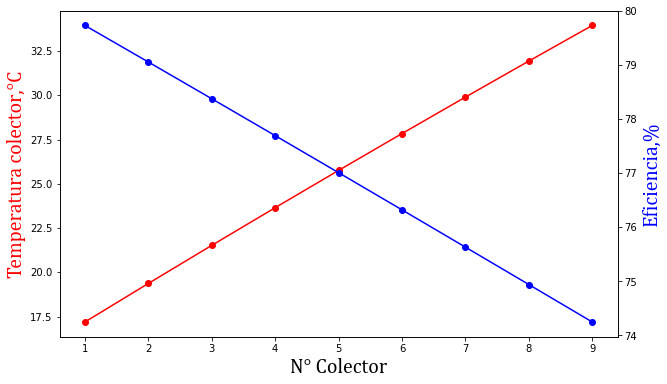

In [181]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(10,6))
# make a plot
ax.plot(x, T_col, color="red", marker="o")
# set x-axis label
ax.set_xlabel("N° Colector",fontsize=20,name='Cambria')
# set y-axis label
ax.set_ylabel("Temperatura colector,°C",color="red",fontsize=20,name='Cambria')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x, Eta_col*100,color="blue",marker="o")
ax2.set_ylabel("Eficiencia,%",color="blue",fontsize=20,name='Cambria')
plt.show()

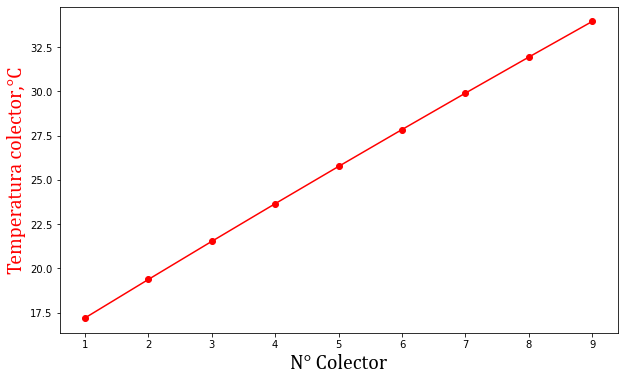

In [229]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(10,6))
# make a plot
ax.plot(x, T_col, color="red", marker="o")
# set x-axis label
ax.set_xlabel("N° Colector",fontsize=20,name='Cambria')
# set y-axis label
ax.set_ylabel("Temperatura colector,°C",color="red",fontsize=20,name='Cambria')
plt.show()

In [2]:
def C_K(T_C):
    return T_C+273.15
def K_C(T_K):
    return T_K-273.15
def bar_Pa(P_bar):
    return P_bar*10**5
def Pa_bar(P_Pa):
    return P_Pa/10**5
def kj_j(kj):
    return kj*1000
def j_kj(j):
    return j/1000
def x_x(Q):
    return Q

def State(fluid,v1_name,v1_value,v2_name,v2_value):
    
    def C_K(T_C):
        return T_C+273.15
    def K_C(T_K):
        return T_K-273.15
    def bar_Pa(P_bar):
        return P_bar*10**5
    def Pa_bar(P_Pa):
        return P_Pa/10**5
    def kj_j(kj):
        return kj*1000
    def j_kj(j):
        return j/1000
    def x_x(Q):
        return Q
    
    '''
    Function that calculates state variables of a certain fluid using CoolProp library.
    
    Inputs:
    --------
        -fluid   : String that indicates the name of the fluid whose state variables will be calculate
        -v1_name : String that indicates the name of the first input variable
        -v1_value: String that indicates the value of the first input variable
        -v2_name : String that indicates the name of the second input variable
        -v2_value: String that indicates the value of the second input variable
        
        
    Outpus: 
    ---------
        -state: Dictionary that contains the state variables of the fluid. 
                This dictionary has the following format: state={'T':T_value, #Temperature, °C
                                                                 'P':P_value, #Pressure, bar
                                                                 'H':H_value, #Specific enthalpy, kJ/kg
                                                                 'Q':Q_value, #Mass vapor quality, mol/mol
                                                                 'S':S_value, #Specific entropy, kJ/(kg*K)
                                                                 'C':C_value, #Specific constant pressure specific heat, kJ/(kg*K)
                                                                 'U':U_value, #Specific energy, kJ/kg
                                                                 'D':D_value, #Mass density, kg/m^3} 
    '''
    
    values_list=['T','P','H','Q','S','C','U','D'] #List that contains the names of differente state variables 
    
    values_convertion_1={'T':C_K,'P':bar_Pa,'H':kj_j,'Q':x_x,'S':kj_j,'C':kj_j,'U':kj_j,'D':x_x} #Dictionaries that contains 
    values_convertion_2={'T':K_C,'P':Pa_bar,'H':j_kj,'Q':x_x,'S':j_kj,'C':j_kj,'U':j_kj,'D':x_x} #unity convertion functions
    
    state={'fluid':fluid} #Create a dictionary to save the states variables
    
    for value in range(len(values_list)): #loop that goes throw the variables that will be calculate 
        
        state[values_list[value]]=CP.PropsSI(values_list[value], # Declares what variable will be calculate with PropsSI
                                             v1_name,values_convertion_1[v1_name](v1_value), #Declares the name and the value of the firs input variable
                                             v2_name,values_convertion_1[v2_name](v2_value), #Declares the name and the value of the second input variable
                                             fluid) #Declares the fluid 
        
        state[values_list[value]]=values_convertion_2[values_list[value]](state[values_list[value]]) #Saves the state variable with the units
                                                                                                     #declares in the output section
    return state

In [331]:
def Irradiance_2(latitude,longitude,UTC,DATA,tilt=35,azimuth=354,albedo=0.2): 
    
    '''
    Función que calcula la irradiancia total sobre un plano inclinado con intervalo horario 
    a lo largo de un año. La función utiliza funciones de la librería pvlib para calcular 
    independientemente: Radiación directa, radiación difusa y radiación reflejada en
    el suelo por sobre una superficie inclinada. Posteriormente, se entrega un vector de 8760*1,
    donde cada componente es la suma de las tres radiaciones mencionadas anteriormente por hora.
    
    Parámetros:
    ----------
        -latitude : Latitud en grados. Positivo para el norte del ecuador, negativo para el sur. 
        -longitude: Longitud en grados. Positivo para el este del meridiano cero, negativo para el oeste.
        -UTC      : UTC de la zona horaria a analizar.
        -GHI      : 
        -DNI      :
        -DHI      : Vector de irradiacia difusa, W/m2
        -tilt     : Ángulo de inclinación de la superficie a analizar con respecto a la horizontal, °
        -azimuth  : Azimut de la superficie a analizar, °
        -albedo   : Albedo de la superficie que se desea analizar. 
        
    Outputs:
    --------
        -Vector de 8760*1 donde se entrega la irradiancia total sobre el plano inclinado, W/m2
        
    '''
    GHI=DATA['GHI'].values
    DNI=DATA['DNI'].values
    DHI=DATA['DHI'].values
    
    tz = f'Etc/GMT+{UTC}'  #Se establece la zona horaria por medio de UTC
    
    times = pd.date_range('2021-01-01 00:00:00', '2022-01-01', closed='left',freq='H', tz=tz) # Se genera un dataframe 
                                                                                              # con con un time-step horario
                                                                                              # de todo un año
    
    solpos = pv.solarposition.ephemeris(times, latitude, longitude) #Se obtiene la posición solar para la locación a analizar
    
    solar_azimuth=solpos['azimuth']           # Vector de azimuth de la posición solar anual, °
    solar_zenith=solpos['zenith']             # Vector de zenith de la posición solar anual, °
    apparent_zenith=solpos['apparent_zenith'] # Vector de zenith aparente de la posición solar anual,° 
    
    diff=pv.irradiance.isotropic(tilt,DHI)                                        # Vector de radiación difusa sobre la superficie inclinada, W/m2
    diff_ground=pv.irradiance.get_ground_diffuse(tilt,GHI,albedo)                 # Vector de radiación difusa reflejada en el suelo en la superficie inclinada, W/m2
    dni=pv.irradiance.beam_component(tilt,azimuth,solar_zenith,solar_azimuth,DNI) # Vector de radiación directa en la superficie inclinada, W/m2
    
    return dni,diff,diff_ground